In [1]:
# importing modules

import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import (InputLayer, Conv2D, MaxPooling2D, MaxPool2D, Flatten, 
                          Dense, BatchNormalization, Dropout, ELU, UpSampling2D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Nadam
from keras.layers import Input, Multiply, UpSampling2D
from keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

2024-05-29 08:52:21.409281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 08:52:21.409381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 08:52:21.593053: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    print()

    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [3]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split

def is_image_dark(image, threshold=30):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray_image)
    return mean_intensity < threshold

def image_to_hash(image):
    resized = cv2.resize(image, (8, 8))
    gray_image = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    return tuple(gray_image.flatten())

def is_grayscale(image):
    if len(image.shape) == 2:  # Image is already grayscale
        return True
    elif len(image.shape) == 3 and image.shape[2] == 1:  # Single-channel image
        return True
    elif len(image.shape) == 3 and image.shape[2] == 3:  # Check if R, G, B channels are equal
        return np.all(image[:,:,0] == image[:,:,1]) and np.all(image[:,:,1] == image[:,:,2])
    return False

def apply_color_jitter(image):
    # Randomly adjust brightness, contrast, saturation, and hue
    brightness = np.random.uniform(0.8, 1.2)
    contrast = np.random.uniform(0.8, 1.2)
    saturation = np.random.uniform(0.8, 1.2)

    # Convert image to float32 for calculations
    image = image.astype(np.float32) / 255.0

    # Adjust brightness
    image *= brightness

    # Adjust contrast
    image = (image - 0.5) * contrast + 0.5
    image = np.clip(image, 0, 1)

    # Adjust saturation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = np.stack([gray_image] * 3, axis=-1)  # Convert grayscale to 3 channels
    image = image * saturation + gray_image * (1 - saturation)

    # Convert back to uint8
    image = (image * 255).astype(np.uint8)
    
    return image

data_dir = "/kaggle/input/mushroom-classification/archive/Mushrooms"

# Create a mapping between category names and integer labels
category_map = {category: idx for idx, category in enumerate(sorted(os.listdir(data_dir)))}

# Load the dataset
images_list = []
labels_list = []
max_images_per_category = 300
seen_hashes = set()

for label_dir in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label_dir)
    if os.path.isdir(label_path):
        label = category_map[label_dir]  # Get the integer label from the mapping
        category_images = 0
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            try:
                image = cv2.imread(image_path)
                if image is not None:
                    # Check if the image is grayscale
                    if is_grayscale(image):
                        continue

                    # Check if the image is dark
                    if is_image_dark(image):
                        continue

                    # Check for duplicates
                    image_hash = image_to_hash(image)
                    if image_hash in seen_hashes:
                        continue
                    seen_hashes.add(image_hash)

                    # Apply color jitter
                    jittered_image = apply_color_jitter(image)

                    # Resize the image to 400x400
                    resized_image = cv2.resize(jittered_image, (200, 200))

                    images_list.append(resized_image)
                    labels_list.append(label)
                    category_images += 1

                    # Stop loading images for this category once we reach the limit
                    if category_images >= max_images_per_category:
                        break
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                continue

# Convert to numpy arrays
images_array = np.array(images_list)
labels_array = np.array(labels_list)

# Normalize the images
images_array = images_array / 255.0

# One-hot encode the labels
num_categories = len(category_map)
predictor_labels = np.eye(num_categories)[labels_array]

# Split the data
x_train, x_temp, y_train, y_temp = train_test_split(images_array, predictor_labels, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Print shapes
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)


Premature end of JPEG file


x_train: (1890, 200, 200, 3)
y_train: (1890, 9)
x_test: (405, 200, 200, 3)
y_test: (405, 9)
x_val: (405, 200, 200, 3)
y_val: (405, 9)


In [13]:
from keras.regularizers import l2

model = Sequential() # sequential model

model.add(InputLayer(shape=(200,200, 3)))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

# callbacks: model checkpoint and reducing lr on plateau for focusing model towards problem
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.compile(optimizer=Nadam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) # compiling model layers

model.summary() # model summary

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    20,480,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,737,545 (79.11 MB)

 Trainable params: 20,737,545 (79.11 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:

history = model.fit(x_train,y_train,batch_size=32,epochs=50,verbose=1,validation_data=(x_val,y_val),callbacks=[reduce_lr,model_checkpoint])

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.1116 - loss: 2.2177
Epoch 1: val_accuracy improved from -inf to 0.13086, saving model to model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - accuracy: 0.1118 - loss: 2.2175 - val_accuracy: 0.1309 - val_loss: 2.1809 - learning_rate: 1.0000e-04
Epoch 2/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2001 - loss: 2.1415
Epoch 2: val_accuracy improved from 0.13086 to 0.21235, saving model to model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.2007 - loss: 2.1405 - val_accuracy: 0.2123 - val_loss: 2.0963 - learning_rate: 1.0000e-04
Epoch 3/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2952 - loss: 1.9821
Epoch 3: val_accuracy improved from 0.21235 to 0.24198, saving model to model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.2953 - loss: 1.9812 - val_accuracy: 0.2420 - val_loss: 2.0166 - learning_rate: 1.0000e-04
Epoch 4/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accurac

In [15]:
# loading best model and testing

model1 = keras.models.load_model('model.keras', custom_objects={"ELU": keras.layers.ELU,"PReLU": keras.layers.PReLU}) # loading saved model

y_test_categorical = np.argmax(y_test, axis=1) # turning y_test probability distributions back to labels

y_pred_prob_val = model1.predict(x_test) # predicting

y_pred_val = np.argmax(y_pred_prob_val, axis=1) # turning y_pred probability distributions back to labels

# Accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_val)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test_categorical, y_pred_val, average='macro')
print("Precision:", precision)

# Recall
recall = recall_score(y_test_categorical, y_pred_val, average='macro')
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test_categorical, y_pred_val, average='macro')
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_categorical, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Accuracy: 0.34074074074074073
Precision: 0.3393238928780268
Recall: 0.3377516776647047
F1 Score: 0.33260347517238953
Confusion Matrix:
[[14  6  2  3  4  2  2  8  0]
 [ 4 19  4  1  3  5  4  4  1]
 [ 0  4 28  3  1  3  4  3  2]
 [ 0  6  6 11  4  6  3  5  7]
 [ 3  6  3  5 17  3  6  5  3]
 [ 1  2  2  2  6 23  3  1  3]
 [ 2  3  5  8  4  4  5  4  2]
 [ 2  6  4  3  8  1  7 12  1]
 [ 1  3  7  6  4  5  7  6  9]]


In [16]:
model1.evaluate(x_test,y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3357 - loss: 2.5664


[2.59678316116333, 0.34074074029922485]

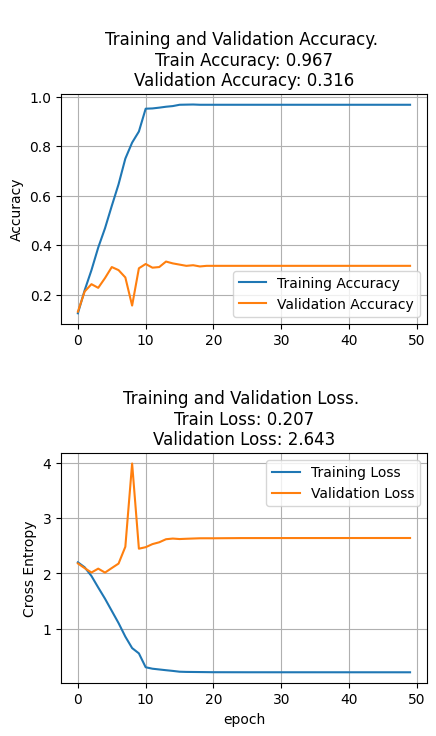

In [17]:
plot_history(history)

In [33]:
from keras.layers import Input, GlobalAveragePooling2D, Multiply, UpSampling2D
from keras.models import Model

def simple_attention(inputs):

    attention = Dense(inputs.shape[-1], activation='softmax')(inputs)
    
    attention = Multiply()([inputs, attention])
    
    return attention

# Input layer
inputs = Input(shape=(200, 200, 3), name='input_layer')

# Layer 1
layer1 = Conv2D(filters=32, kernel_size=3, activation='relu', padding="same")(inputs)
layer1 = BatchNormalization()(layer1)
layer1 = MaxPool2D()(layer1)

# Layer 2
layer2 = Conv2D(filters=32, kernel_size=3, activation='relu', padding="same")(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = MaxPool2D()(layer2)

# Layer 3
layer3 = Conv2D(filters=64, kernel_size=3, activation='relu', padding="same")(layer2)
layer3 = BatchNormalization()(layer3)
layer3 = MaxPool2D()(layer3)

layer3 = Conv2D(filters=64, kernel_size=3, activation='relu', padding="same")(layer3)
layer3 = BatchNormalization()(layer1)

# Layer 2
layer3 = Conv2D(filters=64, kernel_size=3, activation='relu', padding="same")(layer3)
layer3 = BatchNormalization()(layer2)

attention_layer = simple_attention(layer3)

# Flatten and dense layers
flattened = Flatten()(attention_layer)
dense1 = Dense(256, activation='relu')(flattened)
dense1 = BatchNormalization()(dense1)
dense1 = Dense(128, activation='relu')(dense1)
dense1 = BatchNormalization()(dense1)
dense1 = Dense(64, activation='relu')(dense1)
dense1 = BatchNormalization()(dense1)

outputs = Dense(9, activation='softmax')(dense1)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.compile(optimizer=Nadam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 200, 200,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        128 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 100, 100,  │      9,248 │ max_pooling2d_18… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        128 │ max_pooling2d_19… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 50, 50,    │      1,056 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Multiply)          │ 32)               │            │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 80000)     │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 256)       │ 20,480,256 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_23[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_24[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_25[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 9)         │        585 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 20,535,369 (78.34 MB)

 Trainable params: 20,534,281 (78.33 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [34]:

history = model.fit(x_train,y_train,batch_size=32,epochs=50,verbose=1,validation_data=(x_val,y_val),callbacks=[reduce_lr,model_checkpoint])

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1544 - loss: 2.4378
Epoch 1: val_accuracy improved from -inf to 0.12099, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.1550 - loss: 2.4348 - val_accuracy: 0.1210 - val_loss: 2.7875 - learning_rate: 0.0100
Epoch 2/50
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2260 - loss: 2.0971
Epoch 2: val_accuracy improved from 0.12099 to 0.22222, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.2269 - loss: 2.0954 - val_accuracy: 0.2222 - val_loss: 2.3220 - learning_rate: 0.0100
Epoch 3/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3331 - loss: 1.8591
Epoch 3: val_accuracy did not improve from 0.22222
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3331 - loss: 1.8593 - val_accuracy: 0.2074 - val_loss: 2.2823 - learning_rate: 0.0100
Epoch 4/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3866 - loss: 1.7089
Epoch 4: val_a

In [35]:
# testing model 

model2 = keras.models.load_model('att_model.keras', custom_objects={"ELU": keras.layers.ELU,"PReLU": keras.layers.PReLU}) # loading saved model

y_test_categorical = np.argmax(y_test, axis=1) # turning y_test probability distributions back to labels

y_pred_prob_val = model2.predict(x_test) # predicting

y_pred_val = np.argmax(y_pred_prob_val, axis=1) # turning y_pred probability distributions back to labels

# Accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_val)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test_categorical, y_pred_val, average='macro')
print("Precision:", precision)

# Recall
recall = recall_score(y_test_categorical, y_pred_val, average='macro')
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test_categorical, y_pred_val, average='macro')
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_categorical, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Accuracy: 0.2419753086419753
Precision: 0.24203705646093057
Recall: 0.24377683151164187
F1 Score: 0.23945731680955148
Confusion Matrix:
[[ 8  9  5  6  0  1  7  4  1]
 [ 7 15  4  1  3  6  5  3  1]
 [ 1  3 13  4  6  8  6  2  5]
 [ 3  4  5  7  5  9  4  3  8]
 [ 3  5  4  3 12  7  7  6  4]
 [ 3  2  2  4  6 16  4  3  3]
 [ 0  2  4  8  6  3 10  3  1]
 [ 5  3  5  3  8  1  6  9  4]
 [ 2  3  5  5  0 10  9  6  8]]


In [36]:
model2.evaluate(x_test,y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2125 - loss: 2.9398


[2.8527863025665283, 0.2419753074645996]

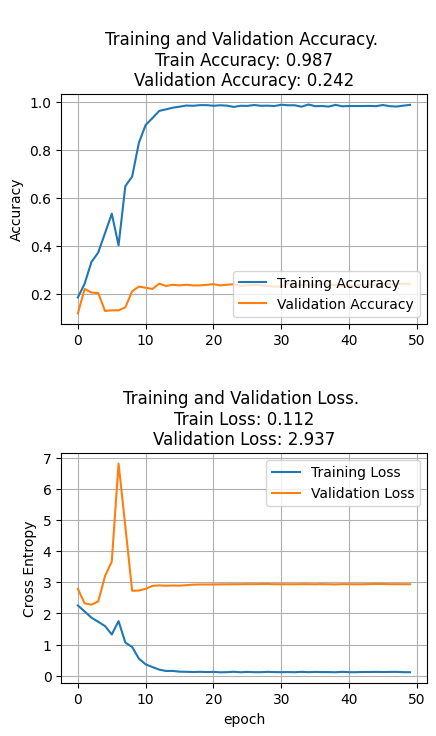

In [37]:
plot_history(history)